In [118]:
import pandas as pd
import networkx as nx
import random

In [238]:
airports_df = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat',
    names=['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude',
        'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source'], index_col=0)

airlines_df = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat',
    names=['Airline ID', 'Name', 'Alias', 'IATA', 'ICAO', 'Callsign', 'Country', 'Active'], index_col=0)

routes_df = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat',
    names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport',
        'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])

planes_df = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/planes.dat',
    names=['Name', 'IATA code', 'ICAO code'])

In [239]:
airports_df = airports_df.replace({r'\N': None})

airlines_df = airlines_df.fillna('')
airlines_df = airlines_df.replace({r'\N': None})

routes_df = routes_df.fillna('')
routes_df = routes_df[(routes_df['Destination airport'].isin(airports_df['IATA'])) & (routes_df['Source airport'].isin(airports_df['IATA']))]

In [240]:
drop_cols = ['Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source', 'ICAO']
airports_df = airports_df.drop(drop_cols, axis=1, errors='ignore')
airports_df

,Name,City,Country,IATA
Airport ID,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA
2,Madang Airport,Madang,Papua New Guinea,MAG
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM
...,...,...,...,...
14106,Rogachyovo Air Base,Belaya,Russia,None
14107,Ulan-Ude East Airport,Ulan Ude,Russia,None
14108,Krechevitsy Air Base,Novgorod,Russia,None


In [241]:
G = nx.MultiDiGraph()
G.add_nodes_from(airports_df['IATA'])
G.add_edges_from(list(routes_df[['Source airport', 'Destination airport']].to_records(index=False)))
airports_df['out_degree'] = airports_df.apply(lambda x: G.out_degree[x['IATA']], axis=1)
airports_df['in_degree'] = airports_df.apply(lambda x: G.in_degree[x['IATA']], axis=1)
airports_df

,Name,City,Country,IATA,out_degree,in_degree
Airport ID,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,5,5
2,Madang Airport,Madang,Papua New Guinea,MAG,8,8
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,10,12
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,11,11
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,49,48
...,...,...,...,...,...,...
14106,Rogachyovo Air Base,Belaya,Russia,None,0,0
14107,Ulan-Ude East Airport,Ulan Ude,Russia,None,0,0
14108,Krechevitsy Air Base,Novgorod,Russia,None,0,0


In [473]:
num_iterations = 20
max_people_interactions = 100
p_spread = .01
people_states = {d['IATA'] : [d['out_degree']]+[0]*num_iterations for d in airports_df.to_dict('records')}
infected_states = {k: [0]*(num_iterations+1) for k in people_states}

infected_states['HSV'][0] = 1

for t in range(num_iterations):
    # travel stage
    for airport in people_states:
        destinations = sum(([n]*G.number_of_edges(airport, n) for n in G.neighbors(airport)), [])
        random.shuffle(destinations)
        destinations = destinations[:people_states[airport][t]]
        infected_list = [True]*infected_states[airport][t] + [False]*(people_states[airport][t]-infected_states[airport][t])
        random.shuffle(infected_list)
        infected_list_traveling = infected_list[:people_states[airport][t]]
        for destination, is_infected in zip(destinations, infected_list_traveling):
            people_states[destination][t+1] += 1
            infected_states[destination][t+1] += is_infected
        
        people_states[airport][t+1] += max(0, people_states[airport][t] - len(destinations))
        infected_states[airport][t+1] += sum(infected_list[people_states[airport][t]:])

    # infection stage
    for airport in infected_states:
        i = infected_states[airport][t+1]
        s = people_states[airport][t+1] - i
        new_i = len(list(filter(lambda x: x > (1-p_spread)**i, [random.random() for i in range(min(s, max_people_interactions))])))
        infected_states[airport][t+1] = i + new_i

In [474]:
df = pd.DataFrame(dict({'airport': a}, **{str(i):infected_states[a][i] for i in range(num_iterations)}) for a in infected_states)
df[df['airport']=='ATL']

,airport,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
2873,ATL,0,0,0,2,0,0,0,1,5,...,824,816,817,827,816,827,803,810,825,805


In [475]:
for k in infected_states:
    if infected_states[k][3] > 0:
        print(k, infected_states[k])

PIT [0, 0, 0, 1, 0, 0, 0, 0, 4, 4, 1, 2, 1, 0, 3, 6, 15, 20, 21, 41, 53, 57, 59, 64, 68, 67, 69, 61, 68, 65, 66, 66, 66, 67, 65, 67, 65, 63, 66, 66, 63]
DFW [0, 0, 0, 1, 3, 0, 3, 0, 5, 0, 5, 6, 10, 8, 40, 56, 61, 127, 155, 227, 287, 372, 422, 430, 432, 419, 422, 417, 421, 421, 423, 421, 420, 418, 417, 431, 416, 414, 419, 412, 412]
ATL [0, 0, 0, 2, 0, 0, 0, 1, 5, 4, 11, 6, 30, 41, 51, 89, 126, 209, 273, 404, 506, 645, 738, 818, 830, 844, 843, 826, 817, 823, 824, 816, 817, 827, 816, 827, 803, 810, 825, 805, 800]
JFK [0, 0, 0, 3, 0, 3, 0, 2, 0, 5, 5, 7, 7, 19, 24, 30, 72, 114, 164, 216, 318, 355, 417, 422, 422, 410, 422, 417, 415, 416, 424, 418, 425, 408, 423, 400, 409, 389, 403, 399, 410]


In [476]:
total_population = sum((people_states[p][0] for p in people_states))
total_population

66934

[1, 4, 4, 7, 14, 27, 49, 77, 131, 216, 358, 581, 981, 1646, 2670, 4490, 7211, 11437, 17644, 25792, 35417, 44945, 52339, 56334, 58220, 59137, 59668, 59907, 60070, 60112, 60119, 60058, 59979, 59853, 59813, 59694, 59681, 59575, 59416, 59344, 59297]


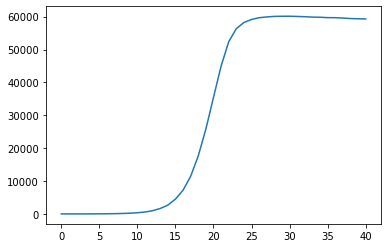

In [477]:
import matplotlib.pyplot as plt
total_infected = [sum((infected_states[i][t] for i in infected_states)) for t in range(num_iterations+1)]
print(total_infected)
plt.plot(total_infected)

In [298]:
total_population

66934